# Classical/Frequentist Statistical Inference: II

*S. R. Taylor (2025)*

Material in this lecture and notebook is based upon the "Maximum Likelihood and Applications in Astronomy" lectures of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18). Also the "Inference" lectures of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 4.
- [David Hogg's "Fitting A Model To Data"](https://arxiv.org/abs/1008.4686)

***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Contents
* [Fitting A Line To Data](#one)
* [Goodness Of Fit & Model Comparison](#two)
* [Confidence Estimating: Bootstrapping & Jackknifing](#three)
---

## Fitting A Line To Data <a class="anchor" id="one"></a>


Continuing the theme of last lecture, let's look at one of the most common tasks in statistical inference: **fitting a line to data**. We won't always fit a straight line, but they are prevalent in astronomy since we're potentially examining data over several orders of magnitude. Hence power-law relationships ($y\propto x^\alpha$) become linear relationships in log-log space ($\ln y \propto \alpha\ln x + \mathrm{constant}$).

Assume the noise/scatter in our measurements (the residuals) is generated by a Gaussian process, i.e.:

$$ y_i = a x_i + b + r_i $$

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the measurement uncertainty, which we take to be the same for all points. The data model includes a linear relationship with two parameters $a,b$: hence the model is written as $M(a,b)$.

Let us compute the likelihood. First, we ask ourselves what is the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured. It is just the normal distribution:

$$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right). $$

The likelihood for all data points is given by the product over $N$ of these terms. Given our previous definitions we can then write down the $\ln L$ as

$$ \ln L(a, b) = \mathrm{constant} - \frac{1}{2} \sum_{i=1}^N \frac{(y_i - M(x_i))^2}{\sigma^2} = \mathrm{constant} - \frac{1}{2} \chi^2$$

This is the expression that we now ***maximize*** with respect to $a$ and $b$ to find ML estimators for those parameters. This is equivalent to ***minimizing*** the sum of the squares (the $\chi^2$) in a *least-squares method*.

In [1]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
from astroML.datasets import fetch_hogg2010test

The following cell will read in some data and peform a least-squares (or $\chi^2$) fit of a linear relationship. It is minimizing the $\chi^2$ (since this is Gaussian data this means it's also maximizing the likelihood) for both $a$ (the slope) and $b$ (the $y$-intercept). 

The data contains some **poorly modeled outliers** too, which have very different uncertainties from what we assume. We'll look at the case without outliers first to build intuition. 

***The outlier points are the first 4 in the dataset.***

<font color='red'>Read through and understand the whole thing before you execute it.</font> 

In [2]:
#------------------------------------------------------------
# Get data from AstroML: this includes outliers
data = fetch_hogg2010test()
x = data['x'] # x data
y = data['y'] # y data
dy = data['sigma_y'] # uncertainties on y data

# Define the standard squared-loss function.
# This is just another name for chi^2
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)

# define a lambda function that defines the sum of squared errors.
# these lambda functions are useful!
# let's initially exclude the outliers by chopping off the first 4 points.
f_squared = lambda beta: squared_loss(beta[0], beta[1], 
                                      x=x[4:], y=y[4:], 
                                      dy=dy[4:])

#------------------------------------------------------------
# compute the maximum likelihood 
beta0 = (1, 30) # initial guess for a and b
beta_squared = optimize.fmin(f_squared, beta0)

Optimization terminated successfully.
         Current function value: 18.680770
         Iterations: 53
         Function evaluations: 106


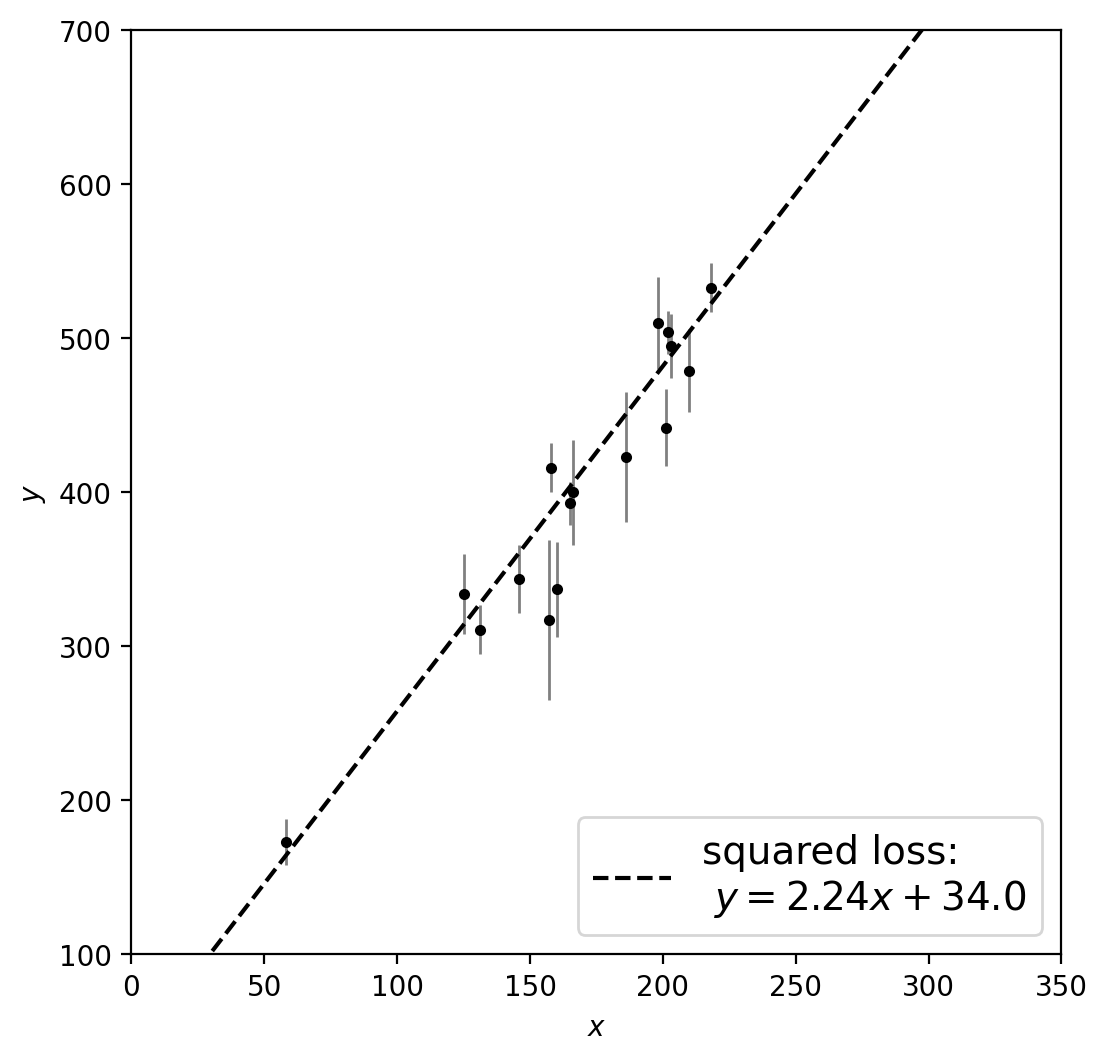

In [3]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')

# plot the best fit linear relationship
x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

We'll now include the outlier data points to see how they contaminate the fit, i.e. we don't need to exclude any of the points from our fit. <font color='red'>Complete and execute the following cell.</font> 

In [4]:
# complete to include the outliers
f_squared_outlier = lambda beta_outlier: squared_loss(beta_outlier[0], 
                                                      beta_outlier[1], 
                                                      x=x, y=y, dy=dy)


#------------------------------------------------------------
# compute the maximum likelihood 
beta0 = (1,30) # complete for initial guess
beta_squared_outlier = optimize.fmin(f_squared_outlier, beta0)

Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 70
         Function evaluations: 133


<font color='red'>Complete in order to plot the regular and outlier fits on the same figure.</font> 

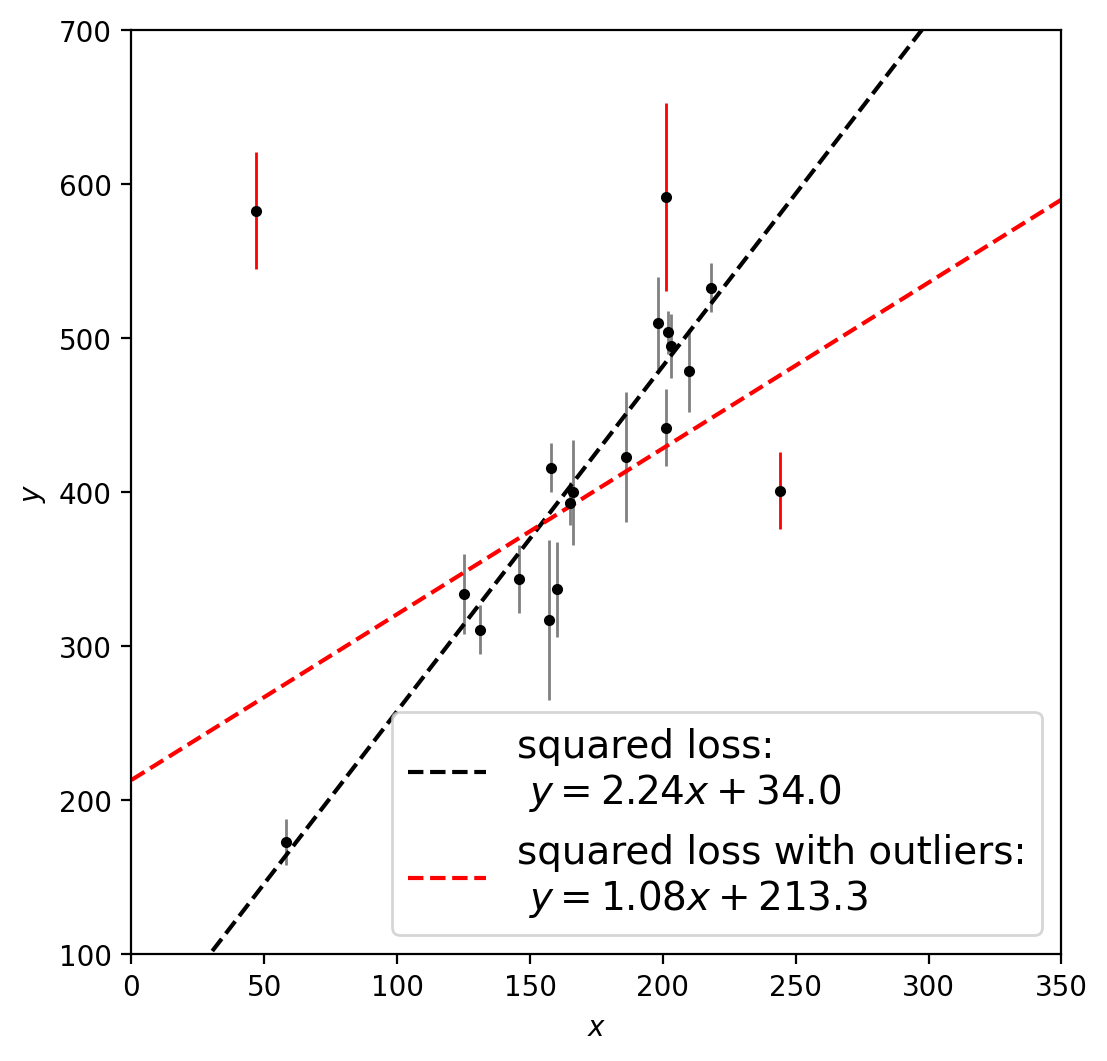

In [6]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data without outliers in gray
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')
# plot the outliers in red
ax.errorbar(x[:3], y[:3], dy[:3], 
            fmt='.k', lw=1, ecolor='red')

x_fit = np.linspace(0, 350, 10)
# plot the regular fit from before without outliers
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
# plot the fit that includes outliers
ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1], 
        ls='--', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

### How do we deal with outliers: modifying the likelihood

- Summing the squares of the residuals ($\chi^2=\sum_{i=1}^N (y_i - M(x_i))^2/\sigma^2$) is sensitive to outliers.

- The $\chi^2$ is an example of an $L_2$ norm (different L, not the likelihood), where the [$L_p$ norm](https://www.wikiwand.com/en/Lp_space) can be defined as $\sum_{i=1}^N (y_i -M(x_i))^p/\sigma^p$.

- A number of approaches exist for correcting for outliers. See in particular [this](https://arxiv.org/abs/1008.4686) great paper. 

- These include "sigma-clipping", using interquartile ranges (which you've seen in previous lectures), taking the median of solutions of subsets of the data, and least trimmed squares (which searchs for the subset of points that minimizes $\sum_i^N (y_i - \theta_ix_i)^2$).


We can also change the **likelihood** to reduce the weight of outliers. This is known as the **Huber loss function**

$$ \sum_{i=1}^N e(y_i|y),$$

where

$$ 
e(t) = \left\{
            \begin{array}{ll}
            \frac{1}{2} t^2 & \text{if} \; |t| \leq c, \\
            c|t| - \frac{1}{2} c^2 & \text{if} \; |t| \geq c,
            \end{array}
        \right ) 
$$

and 

$$ t = \left|\frac{y-M(x)}{\sigma}\right|.$$

This is continuous and differentiable, and transitions to an $L_1$ norm ($\sum_{i=1}^N |y_i - M(x_i)|$) for large data excursions, which downweights the outlier points.

In the image below, the blue curve is the usual $\chi^2$, $L_2$ parabola shape that we attempt to minimize, whereas the green is the alternative Huber loss function that downweights outliers.

![title](https://upload.wikimedia.org/wikipedia/commons/c/cc/Huber_loss.svg)

In [7]:
# Define the log-likelihood via the Huber loss function
def huber_loss(m, b, x, y, dy, c=2):
    y_fit = m * x + b # model
    t = abs((y - y_fit) / dy) # define t
    mask = t > c # define mask for large excursion points
    
    # apply masking to different points
    # note '~' means 'not'
    return np.sum((~mask) * (0.5 * t ** 2) - \
                  (mask) * c * (0.5 * c - t), -1)

# lambda function for huber loss 
f_huber = lambda beta: huber_loss(beta[0], beta[1], 
                                  x=x, y=y, dy=dy, c=1)

#------------------------------------------------------------
# compute the maximum likelihood using the huber loss
beta0 = (1, 30)
beta_huber = optimize.fmin(f_huber, beta0)

Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 62
         Function evaluations: 118


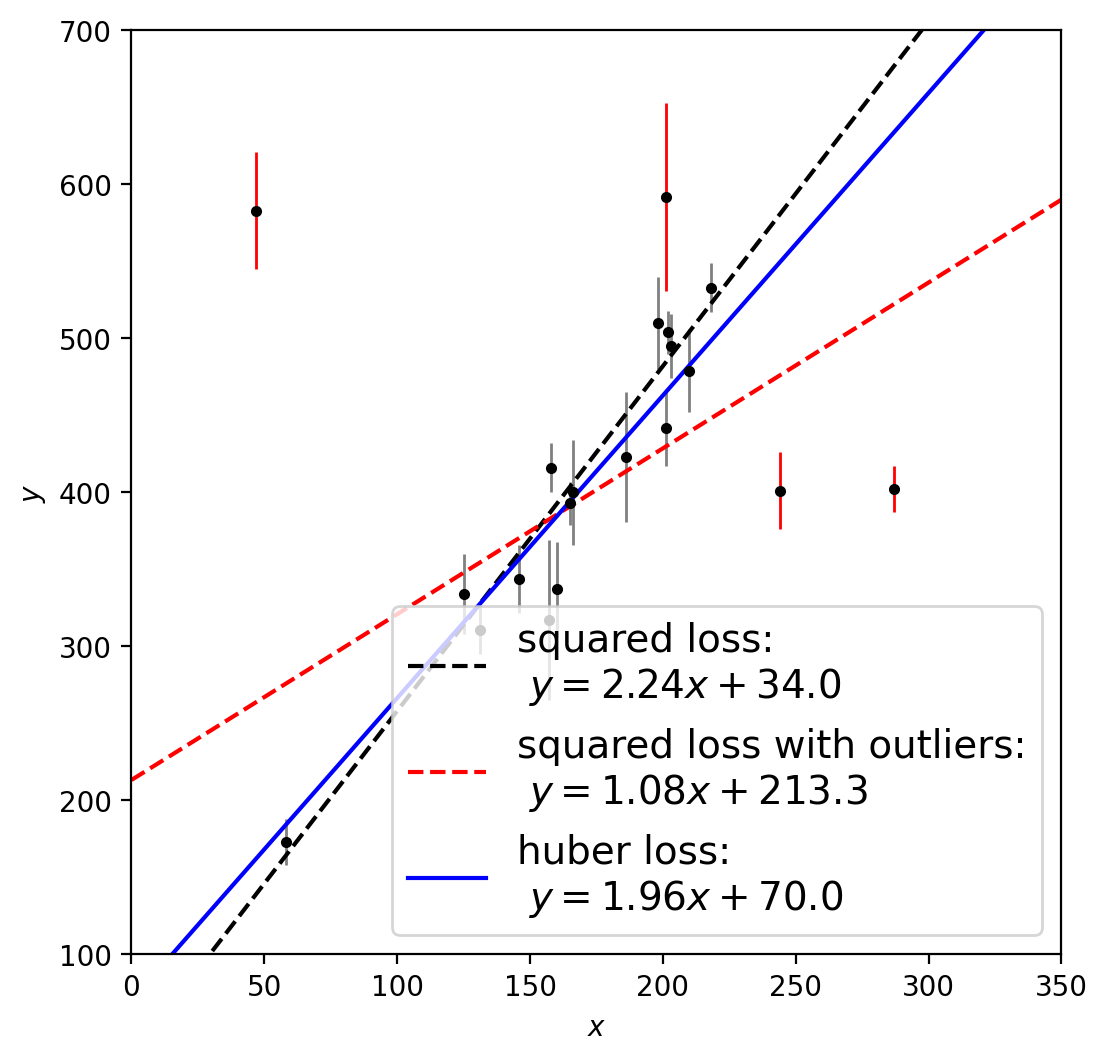

In [8]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data without outliers in gray
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')
# plot the outliers in red
ax.errorbar(x[:4], y[:4], dy[:4], 
            fmt='.k', lw=1, ecolor='red')

x_fit = np.linspace(0, 350, 10)
# plot the regular fit from before without outliers
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
# plot the fit that includes outliers
ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1], 
        ls='--', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))
# plot the fit with the huber likelihood, downweighting outliers
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], 
        ls='-', color='blue',
        label="huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

<font color='red'>Did this help to tame the outliers? Discuss with your colleagues about why.</font> 

In [9]:
#This helped to tame the outliers because the Huber loss function masked the outliers, which helped get a better fit

## Goodness Of Fit & Model Comparison <a class="anchor" id="two"></a>

The MLE approach tells us what the "best" model parameters are, but not how good the fit actually is. If the model is wrong, "best" might not be particularly revealing! Remember this acronym from the dawn of the computer age: ***GIGO = Garbage In, Garbage Out***. 

If we have a crappy model then we shouldn't expect a good fit to the data. For example, if you have $N$ points drawn from a linear distribution, you can always fit the data perfectly with an $N-1$ order polynomial. But that won't help you predict future measurements.

We can describe the **goodness of fit** in words as simply the followng

> *The goodness of fit tells us whether or not it is likely to have obtained the maximum (log-)likelihood $\ln L^0$ by randomly drawing from the data.* 

Using the best-fit parameters of a model, the maximum likelihood value $L^0$ should not be an unlikely occurence. If it is, then our model is not describing the data well. Thus we need to know the *distribution* of $\ln L$ and not just its maximum. For the Gaussian case we have just described, we do a standard transform of variables and compute the so-called $z$ score for each data point (basically the number of standard deviations away from the mean that this point is), writing 

$$z_i = (x_i-\mu)/\sigma,$$ 

then

$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N z_i^2 = {\rm constant} - \frac{1}{2}\chi^2.$$

Here, $\chi^2$ is the thing whose distribution we discussed in early lectures.

**So for Gaussian uncertainties, $\ln L$ is distributed as $\chi^2$.**  

/home/baria/miniconda3/envs/astr8070/lib/python3.13/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


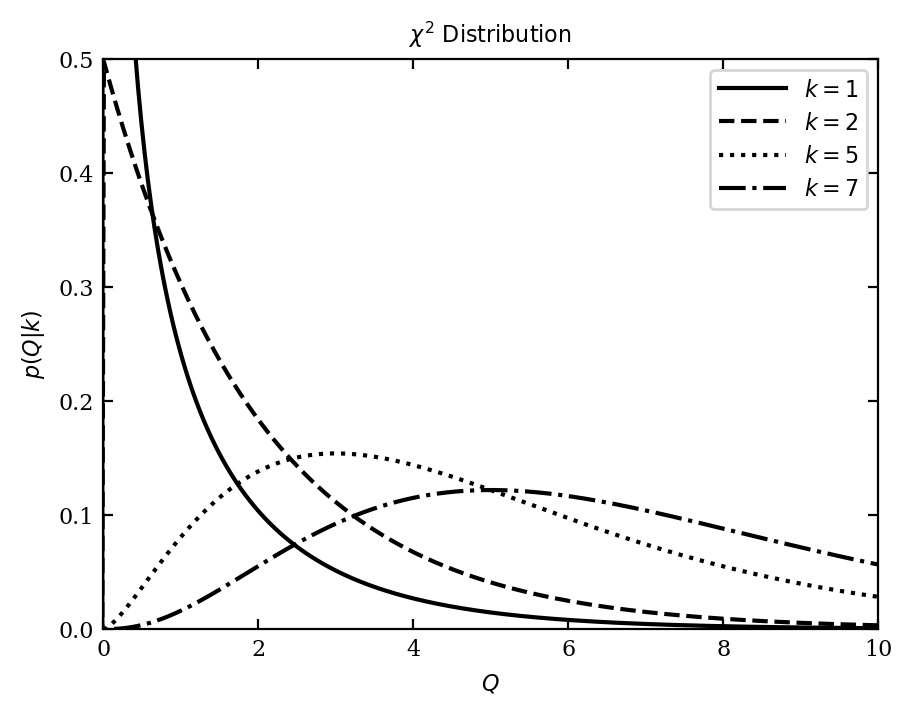

<Figure size 640x480 with 0 Axes>

In [17]:
%run ../../../../lectures/scripts/fig_chi2_distribution.py

***The mean of the $\chi^2$ distribution is $N-k$ and its standard deviation is $\sqrt{2(N-k)}$.***

We define the $\chi^2$ per degree of freedom, $\chi^2_\mathrm{dof}$, as

$$\chi^2_\mathrm{dof} = \frac{1}{N-k}\sum_{i=1}^N z^2_i.$$

where $k$ is the number of model parameters determined from the data.

- For a good fit, we would expect that $\chi^2_\mathrm{dof}\approx 1$. 
- If $\chi^2_\mathrm{dof}$ is significantly larger than 1, or $(\chi^2_\mathrm{dof}-1)>> \sqrt{2/(N-k)}$, then it is likely that we are not using the correct model.
- If data uncertainties are **(over)under-estimated** then this can lead to improbably **(low)high $\chi^2_\mathrm{dof}$**, as seen below.  

![Ivezic, Figure 4.1](http://www.astroml.org/_images/fig_chi2_eval_1.png)

Read through and execute the following cell to compute $\chi^2_\mathrm{dof}-1$ for the line fitted without outliers and fitted with outliers. These will be compared to the standard deviation of the $\chi^2_\mathrm{dof}-1$ distributions.

In [18]:
#------------------------------------------------------------
# Get data from AstroML: this includes outliers
data = fetch_hogg2010test()
x = data['x'] # x data
y = data['y'] # y data
dy = data['sigma_y'] # uncertainties on y data

# number of data points *without* outliers
N = x[4:].shape[0]
# number of data points *with* outliers
N_outlier = x.shape[0]
# number of model parameters (a,b)
k = 2 

# chi2 per dof *without* outliers
chi2 = squared_loss(beta_squared[0], 
                    beta_squared[1], 
                    x=x[4:], y=y[4:], dy=dy[4:])
chi2dof = chi2 / (N-k)

# chi2 per dof *with* outliers
chi2_outlier = squared_loss(beta_squared_outlier[0], 
                            beta_squared_outlier[1], 
                            x=x, y=y, dy=dy)
chi2dof_outlier = chi2_outlier / (N_outlier - k)

# without outliers
print(chi2dof-1, np.sqrt(2/(N-k)))

# with outliers
print(chi2dof_outlier-1, np.sqrt(2/(N_outlier - k)))

0.33434070794594706 0.3779644730092272
15.109095710111468 0.3333333333333333


<font color='red'>For each case, divide the first value by the second value to get the sigma deviation from the desired value of zero. The lower the better. </font> 

In [20]:
# Compute your sigma values here
print((chi2dof-1)/np.sqrt(2/(N-k)))
print((chi2dof_outlier-1)/np.sqrt(2/(N_outlier - k)))

0.8845823663902529
45.327287130334405


### Model Comparison

The distribution of $\ln L$ can only be related to the $\chi^2$ distribution whenever the likelihood is Gaussian. For non-Gaussian likelihoods we can still rank different models in terms of their respectively computed maximum likelihood values, $L^0$. This is only really fair if the models have the same number of parameters.

Let's do that for the data above that contains outliers, both for a model based on the naive squared loss function ($\chi^2$), and a Huber loss function model.

In [21]:
# compute a quantity related to lnL0 for the 
# squared loss function
lnL_sq = - squared_loss(beta_squared_outlier[0], 
                        beta_squared_outlier[1], 
                        x=x, y=y, dy=dy)

# compute a quantity related to lnL0 for the 
# Huber loss function
lnL_huber = - huber_loss(beta_huber[0], 
                         beta_huber[1], 
                         x=x, y=y, dy=dy)

print("Maximum log likelihood for squared loss = %.1f" % lnL_sq)
print("Maximum log likelihood for Huber loss = %.1f" % lnL_huber)

Maximum log likelihood for squared loss = -290.0
Maximum log likelihood for Huber loss = -75.0


We need a modified approach whenever the models we're comparing have different numbers of parameters. Such an approach should account for **model complexity** and **effectively penalize models with additional parameters that are not constrained by the data**. This is often called an ***Occam penalty***, because we're trying to incorporate [Occam's Razor](https://www.wikiwand.com/en/Occam%27s_razor#:~:text=Occam's%20razor%2C%20Ockham's%20razor%2C%20Ocham's,is%20usually%20the%20right%20one.).

> *All else being equal (i.e., each model fits the data equally well), the less complex model is favored.*


We'll meet this in extensive detail later, especially in a Bayesian context. But a popular general-purpose tool for model comparison is the **Akaike Information Criterion** (AIC):

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

where $k$ is the number of model parameters and $N$ is the number of data points.

- For a Gaussian distribution, the first term is equal to $\chi^2$.
- **The model with lowest AIC is the most favored.**
- If all models are equally successful at fitting the data (equal $L^0$ values) then the second and third terms penalize model complexity such that the model with fewest free parameters wins. 

## Confidence Estimating: Bootstrapping & Jackknifing <a class="anchor" id="three"></a>

Most ways of computing confidence limits and ucnertainties on measured model parameters assume that the distribution is Gaussian and our samples are large. But even if that is not the case, we can still compute good confidence intervals (e.g., $a<x<b$ with 95\% confidence) using ***resampling*** strategies.

Remember that we have a data set $\{x_i\}$ from which we have estimated the distribution as $f(x)$ for a true distribution $h(x)$.  

### Bootstrap Method

In bootstrapping, we map the uncertainty of model parameters by re-sampling from our data (with replacement) $B$ times. This is relatively new (Efron, 1979) and was named in inspiration of "*pulling oneself up by one's bootstraps*".

When sampling from observed data of length $N$ with replacement, there are $N!$ distinct combinations of new observed datasets, and there is only a $N!/N^N$ probability of getting back the original dataset (even for $N=10$ this is only $0.00036$). 

With $B$ new bootstrap datasets, we compute our statistics on each to obtain $B$ measures of our parameters. So, if we have $i=1,\dots,N$ data points in $\{x_i\}$, we draw $N$ of them to make a new sample, where some values of $\{x_i\}$ will be used more than once (and this is ok).

**EXAMPLE**
- We have an original dataset of $1000$ points drawn from a Gaussian distribution. 
- We can only measure the standard deviation of the distribution once with this dataset. 
- Our previous strategies showed that we can use a *Fisher estimate* or an *analytic estimate* of the sample standard deviation uncertainty. 
- Instead, we use the bootstrap method to resample the data $10,000$ times, and compute the standard deviation and $\sigma_G$ on each new dataset. 
- This will map out the uncertainty distribution of those statistics, allowing us to quote confidence limits in our actual measured value. 

<font color='red'>Read through the next cell carefully to understand what's happening when you execute it.</font> 

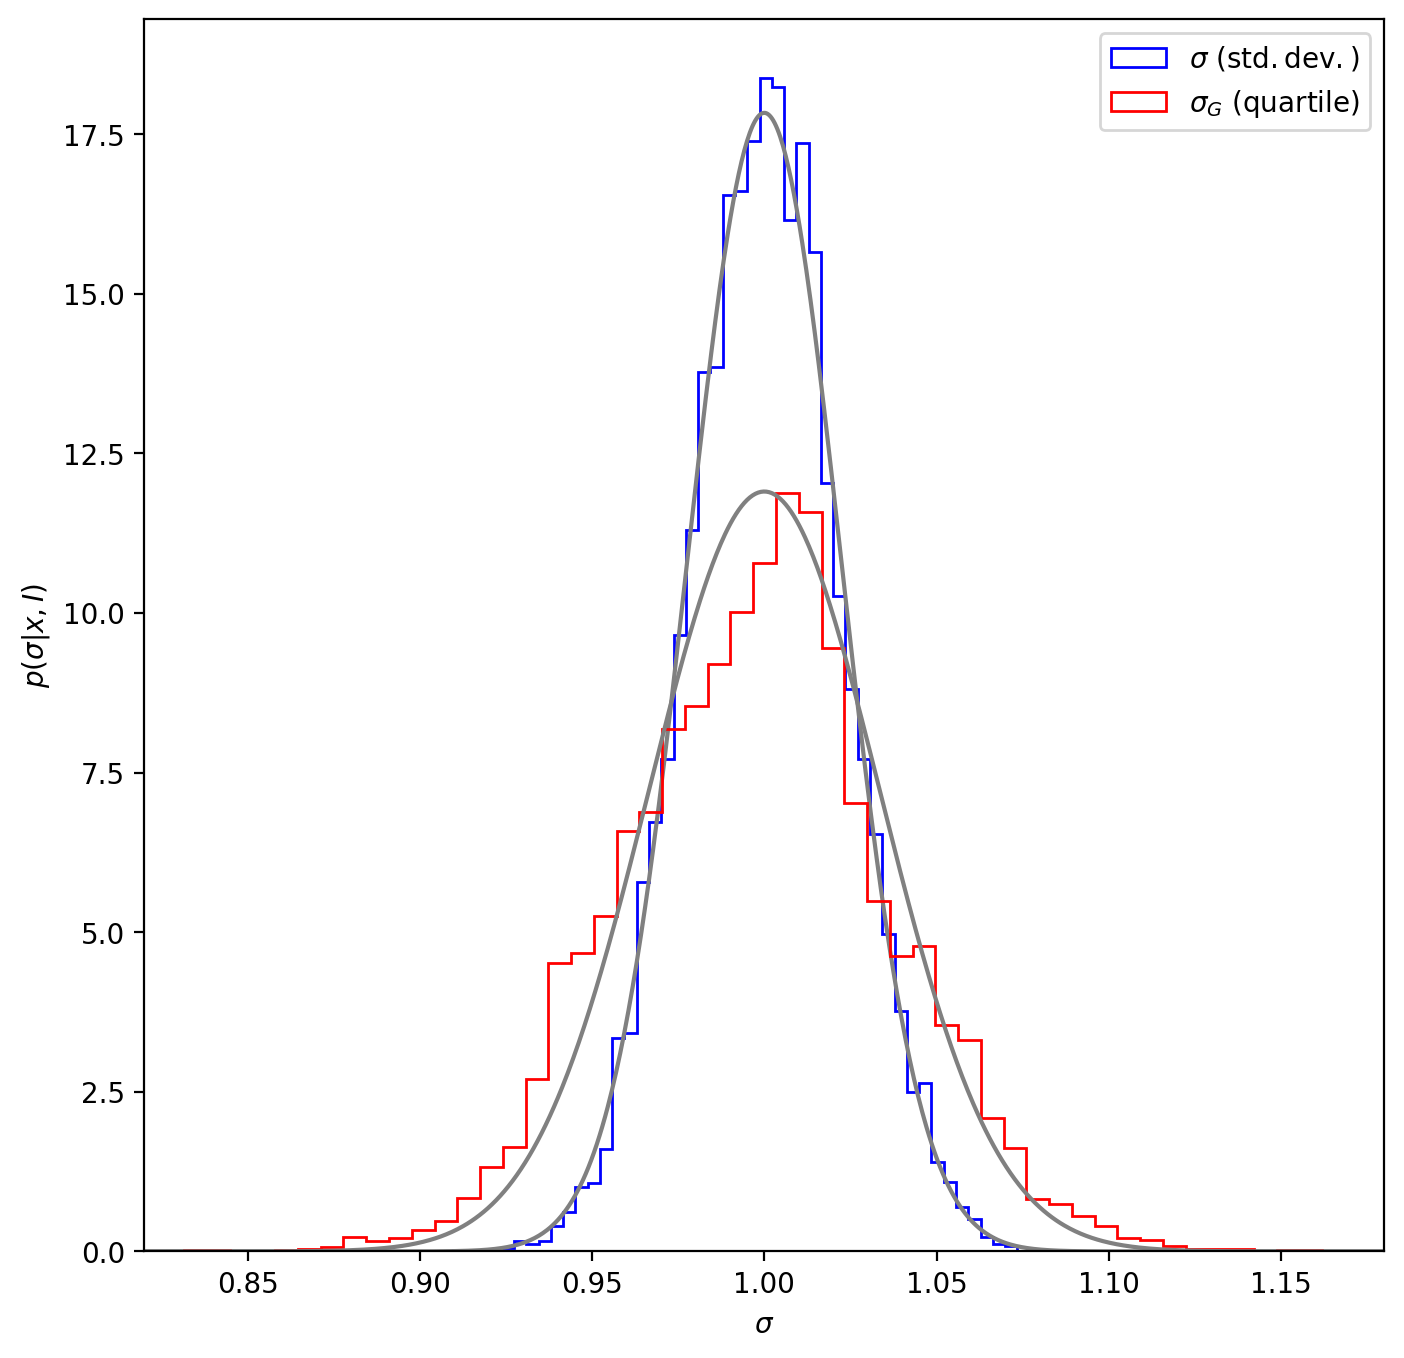

In [27]:
# Ivezic v2, Figure 4.3, modified slightly by GTR and SRT
# %load ../scripts/fig_bootstrap_gaussian.py
# Author: Jake VanderPlas
# License: BSD

from astroML.resample import bootstrap
from astroML.stats import sigmaG

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

#------------------------------------------------------------
# Compute bootstrap resamplings of data
mu1_bootstrap = bootstrap(data, n, np.std, 
                          kwargs=dict(axis=1, ddof=1))
mu2_bootstrap = bootstrap(data, n, sigmaG, 
                          kwargs=dict(axis=1))

#------------------------------------------------------------
# Compute the theoretical expectations for the two distributions
xgrid = np.linspace(0.8, 1.2, 1000)

sigma1 = 1. / np.sqrt(2 * (m - 1))
pdf1 = norm(1, sigma1).pdf(xgrid)

sigma2 = 1.06 / np.sqrt(m)
pdf2 = norm(1, sigma2).pdf(xgrid)

#------------------------------------------------------------
# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))

ax.hist(mu1_bootstrap, bins=50, density=True, 
        histtype='step', color='blue', ls='dashed', 
        label=r'$\sigma\ {\rm (std. dev.)}$')
ax.plot(xgrid, pdf1, color='gray')

ax.hist(mu2_bootstrap, bins=50, density=True, 
        histtype='step', color='red', 
        label=r'$\sigma_G\ {\rm (quartile)}$')
ax.plot(xgrid, pdf2, color='gray')

ax.set_xlim(0.82, 1.18)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')
ax.legend()

plt.show()

The above shows the bootstrap uncertainty estimates for the sample standard deviation $\sigma$ (blue dashed) and $\sigma_G$ (red solid). The thin grey lines show Gaussians with the theoretical widths determined as $\sigma_s = s\, / \sqrt{2(N - 1)}$ and $\sigma_{\sigma_G} = 1.06\, s\, / \sqrt{N}$.

### Jackknife Method 

This is similar to bootsrapping except that we don't use a sample size of $N$. Rather, ***we leave off one or more of the observations*** from $\{x_i\}$. As with bootstrap, we do this multiple times, generating samples from which we can determine our uncertainties.

- If we leave out just one datapoint each time, we can make $N$ such datasets that each contain $(N-1)$ data points.
- We compute our statistic or find our model parameters in each of these jackknife datasets.

For jackknifing by leaving out one datapoint, the bias-corrected jackknife estimate of a statistic $\alpha$ is

$$ \alpha^J = \alpha_N + \Delta\alpha,$$

where $\alpha_N$ is the statistic computed on the original dataset, and 

$$ \Delta\alpha = (N-1)\left( \alpha_N - \frac{1}{N}\sum_{i=1}^N \alpha^*_i \right)$$

where $\{\alpha_i^*\}$ are the statistics computed on the $N$ jackknife datasets. 

For asymptoticically normal estimators, the standard error on $\alpha^J$ is

$$ \sigma_\alpha = \sqrt{\frac{1}{N(N-1)}\sum_{i=1}^N [N\alpha_N - \alpha^J - (N-1)\alpha^*_i]^2}.$$

Confidence limits on $\alpha$ can be computed using the Student's $t$ distribution with $t=(\alpha-\alpha^J)/\sigma_\alpha$ and $(N-1)$ degrees of freedom.

**NOTES**
- The jackknife standard error is more reliable than the bias correction.
- Standard jackknife (removing one point) does well for statistics like the mean and standard deviation, but is poor with rank-based statistics (e.g., median, quantiles, $\sigma_G$). 
- This is because (as we've seen) rank-based statistics are not very sensitive to adding/removing single data points. So jackknifing can give many identical values of the statistic!
- This can be resolved by modifying the jackknife to leave off more than one datapoint.


**EXAMPLE**
- We compute jackknife uncertainty estimates for the width of a Gaussian distribution, using the same data as in the bootstrap example.
- The $N$ jackknife estimates of $\sigma$ and $\sigma_G$ will be shown, but the `astroML` jackknife method automatically incorporates the bias correction mentioned above.

<font color='red'>Read through the next cell carefully to understand what's happening when you execute it.</font>

1.0015366861435233 0.02228013942047898
0.597747861971019 0.031353107946452324
mu_1 mean: 1.00 +- 0.02
mu_2 mean: 0.60 +- 0.03


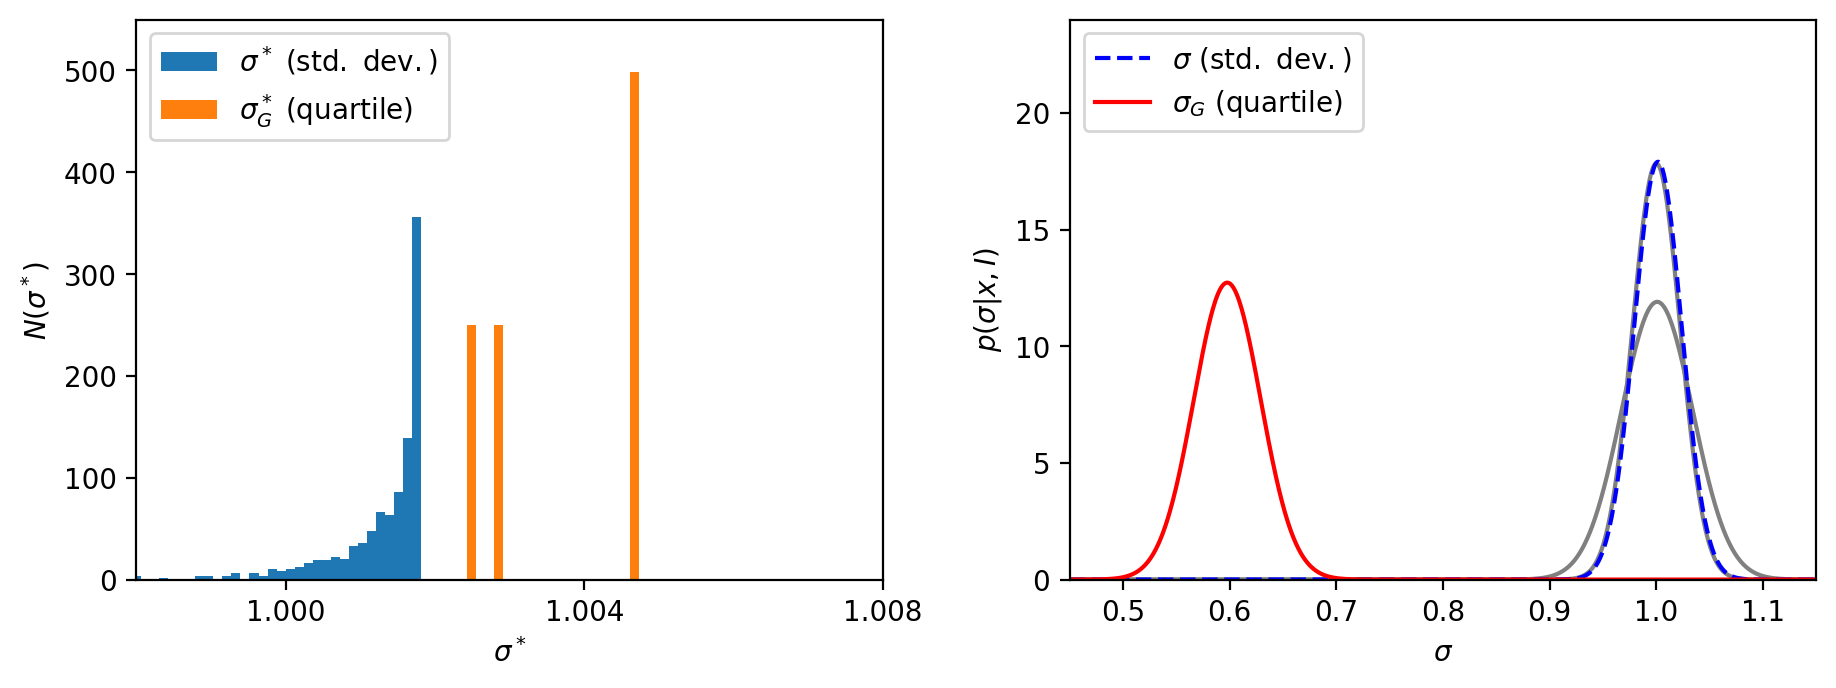

In [23]:
# Ivezic v2, Figure 4.4, modified slightly by SRT
# %load ./scripts/fig_jackknife_gaussian.py
# Author: Jake VanderPlas
# License: BSD

from astroML.resample import jackknife
from astroML.stats import sigmaG

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

# mu1 is the mean of the standard-deviation-based width
mu1, sigma_mu1, mu1_raw = jackknife(data, np.std,
                                    kwargs=dict(axis=1, ddof=1),
                                    return_raw_distribution=True)

pdf1_theory = norm(1, 1. / np.sqrt(2 * (m - 1)))
pdf1_jackknife = norm(mu1, sigma_mu1)
print(mu1, sigma_mu1)

# mu2 is the mean of the interquartile-based width
#  WARNING: do not use the following in practice.  This example
#           shows that jackknife fails for rank-based statistics.
mu2, sigma_mu2, mu2_raw = jackknife(data, sigmaG,
                                    kwargs=dict(axis=1),
                                    return_raw_distribution=True)
pdf2_theory = norm(data.std(), 1.06 / np.sqrt(m))
pdf2_jackknife = norm(mu2, sigma_mu2)
print(mu2, sigma_mu2)

#------------------------------------------------------------
# plot the results
print("mu_1 mean: %.2f +- %.2f" % (mu1, sigma_mu1))
print("mu_2 mean: %.2f +- %.2f" % (mu2, sigma_mu2))

fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(left=0.11, right=0.95, bottom=0.2, top=0.9,
                    wspace=0.25)

# plot all jacnknife results on histogram
ax = fig.add_subplot(121)
ax.hist(mu1_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma^*\ {\rm (std.\ dev.)}$',
        histtype='stepfilled', fc='white', 
        ec='black', density=False)
ax.hist(mu2_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma_G^*\ {\rm (quartile)}$',
        histtype='stepfilled', fc='gray', 
        density=False)
ax.legend(loc='upper left', handlelength=2)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.004))
ax.set_xlabel(r'$\sigma^*$')
ax.set_ylabel(r'$N(\sigma^*)$')
ax.set_xlim(0.998, 1.008)
ax.set_ylim(0, 550)

# plot the bias-corrected jackknife estimates
ax = fig.add_subplot(122)
x = np.linspace(0.45, 1.15, 1000)
ax.plot(x, pdf1_jackknife.pdf(x),
        color='blue', ls='dashed', 
        label=r'$\sigma\ {\rm (std.\ dev.)}$',
        zorder=2)
ax.plot(x, pdf1_theory.pdf(x), 
        color='gray', zorder=1)
ax.plot(x, pdf2_jackknife.pdf(x),
        color='red', 
        label=r'$\sigma_G\ {\rm (quartile)}$', 
        zorder=2)
ax.plot(x, pdf2_theory.pdf(x), 
        color='gray', zorder=1)
plt.legend(loc='upper left', handlelength=2)


ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')
ax.set_xlim(0.45, 1.15)
ax.set_ylim(0, 24)

plt.show()

The **left panel** shows a histogram over all $N$ jackknife datasets of the widths determined using the sample standard deviation, and using $\sigma_G$ (from the interquartile range). 

The **right panel** shows the bias-corrected jackknife estimates (see above) for the two methods. The gray lines show the theoretical results as before in the bootstrap example. The jackknife result for $\sigma$ matches the theoretical result almost exactly, but note the failure of the jackknife to correctly estimate $\sigma_G$. *Jackknifing does poorly for rank-based statistics!*

### When to bootstrap or jackknife?

- Jackknife estimates are usually easier to calculate, easier to apply for complex sampling schemes, and automtically remove bias.
- Bootstrap is better for computing confidence intervals because it maps out the full distribution of the statistic instead of assuming asymptotic normality.
- Bootstrap is random resampling so gives different results each time. Whereas jackknifing gives repeatable results.

It is generally a good idea to use both methods and compare the results. Use either/both with caution with $N$ is small!